### neo4j 社区版 安装

https://hub.docker.com/layers/library/neo4j/4.4.32-community/images/sha256-ce25409b8c3cfaa9a63f4e182753d09266881893e667d0298935ad4bfb0f11e5?context=explore


In [1]:
%%bash
# docker pull neo4j:4.4.32-community
# docker run -d -p 7474:7474 -p 7687:7687 --name neo4j -e "NEO4J_AUTH=neo4j/123456" neo4j:4.4.32-community

http://localhost:7474/browser/  ， 输入用户名、密码，  到达 neo4j 的web控制台


### neo4j基本例子

，来自 https://neo4j.com/docs/api/python-driver/5.18/#quick-example


In [2]:
from neo4j import GraphDatabase, RoutingControl


URI = "neo4j://localhost:7687"
AUTH = ("neo4j", "123456")


def add_friend(driver, name, friend_name):
    driver.execute_query(
        "MERGE (a:Person {name: $name}) "
        "MERGE (friend:Person {name: $friend_name}) "
        "MERGE (a)-[:KNOWS]->(friend)",
        name=name, friend_name=friend_name, database_="neo4j",
    )


def print_friends(driver, name):
    records, _, _ = driver.execute_query(
        "MATCH (a:Person)-[:KNOWS]->(friend) WHERE a.name = $name "
        "RETURN friend.name ORDER BY friend.name",
        name=name, database_="neo4j", routing_=RoutingControl.READ,
    )
    for record in records:
        print(record["friend.name"])


with GraphDatabase.driver(URI, auth=AUTH) as driver:
    add_friend(driver, "Arthur", "Guinevere")
    add_friend(driver, "Arthur", "Lancelot")
    add_friend(driver, "Arthur", "Merlin")
    print_friends(driver, "Arthur")


Guinevere
Lancelot
Merlin


### 可视化neo4j图（以networkx）

In [3]:
%%bash

pip install networkx matplotlib

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


关系relation为 <Relationship element_id='5' nodes=(<Node element_id='0' labels=frozenset({'Person'}) properties={'name': 'Arthur'}>, <Node element_id='3' labels=frozenset({'Person'}) properties={'name': 'Merlin'}>) type='LOVE' properties={}>
关系relation为 <Relationship element_id='4' nodes=(<Node element_id='0' labels=frozenset({'Person'}) properties={'name': 'Arthur'}>, <Node element_id='2' labels=frozenset({'Person'}) properties={'name': 'Lancelot'}>) type='LOVE' properties={}>
关系relation为 <Relationship element_id='3' nodes=(<Node element_id='0' labels=frozenset({'Person'}) properties={'name': 'Arthur'}>, <Node element_id='1' labels=frozenset({'Person'}) properties={'name': 'Guinevere'}>) type='LOVE' properties={}>
关系relation为 <Relationship element_id='2' nodes=(<Node element_id='0' labels=frozenset({'Person'}) properties={'name': 'Arthur'}>, <Node element_id='3' labels=frozenset({'Person'}) properties={'name': 'Merlin'}>) type='KNOWS' properties={}>
关系relation为 <Relationship element_id='

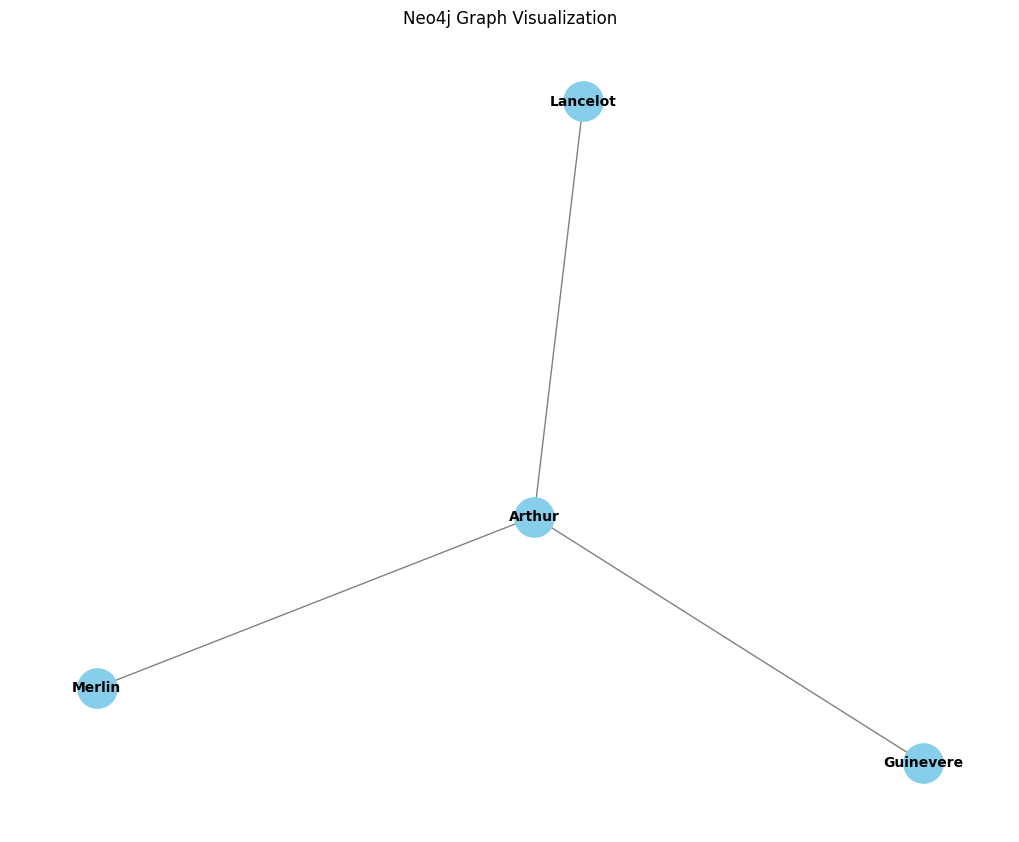

In [4]:
from neo4j import GraphDatabase
import networkx as nx
import matplotlib.pyplot as plt

def visual(driver):
    G = nx.Graph()
    records, _, _ = driver.execute_query(
        "MATCH (n)-[r]->(m)"
        "RETURN n, r, m LIMIT 100",
        database_="neo4j", routing_=RoutingControl.READ,
    )
    for record in records:
        srcV=record['n']['name']
        dstV=record['m']['name']
        relation = record['r']
        print("关系relation为",relation)
        G.add_node(srcV)
        G.add_node(dstV)
        G.add_edge(srcV,dstV,**relation)
    return G



driver= GraphDatabase.driver(URI, auth=AUTH)
G=visual(driver)
driver.close()

pos = nx.spring_layout(G)  # 使用Spring布局算法
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_size=800, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')
plt.title("Neo4j Graph Visualization")
plt.show()